In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# this function / method should NOT be in the MultiRNN class
def split_data(data_path, length):
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    train = df.iloc[:-length]
    test = df.iloc[-length:]

    return train, test

In [3]:
def create_sub_df(train, test):
    # this snippet should be inside of method 
    # "generate_dataset_per_column_with_original_index"
    datasets = {
    "train" : {col:train[col] for col in train.columns},
    "test" : {col:test[col] for col in test.columns}
    }

    return datasets

In [4]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.transform(test)

    return scaled_train, scaled_test, scaler

In [5]:
from keras.preprocessing.sequence import TimeseriesGenerator
def create_generator(scaled_train, scaled_test, 
                     length, batch_size):
    
    generator = TimeseriesGenerator(scaled_train,
                                    scaled_train,
                                    length=length,
                                    batch_size=batch_size)
    
    # create validation generator
    val_generator = TimeseriesGenerator(scaled_test,
                                        scaled_test,
                                        length=length, 
                                        batch_size=batch_size)
    
    return generator, val_generator

2024-05-15 13:47:58.468429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 13:47:58.468454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 13:47:58.489079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 13:47:58.517388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
def create_LSTM(units, activation, loss,
                input_shape, optimizer):
    
    model = Sequential()

    model.add(LSTM(units, activation=activation, 
                    input_shape=input_shape))
    
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss=loss)

    return model

In [7]:
def fit_LSTM(model, generator, val_generator,
             monitor="val_loss", patience=2,
             epochs=10, batch_size=32):
    early_stop = EarlyStopping(monitor=monitor, 
                               patience=patience)

    result = model.fit(generator,
                       validation_data=val_generator,
                       epochs=epochs,
                       callbacks=[early_stop],
                       batch_size=batch_size)
    
    return result

In [8]:
def eval(model, scaled_train, 
         test, length, scaler):
    test_preds = []

    first_eval_batch = scaled_train[-length:]
    current_batch = first_eval_batch.reshape((1, length, 1))

    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_preds.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], 
                                  [[current_pred]], axis=1)
        
    true_predictions = scaler.inverse_transform(test_preds)
    test_df = pd.DataFrame(test)
    test_df["Predictions"] = true_predictions
    
    return test_df

In [9]:
length = 288 # as we have 288 data points for 2 days
train, test = split_data("../data/energydata_complete.csv", length)

In [10]:
train.index

DatetimeIndex(['2016-01-11 17:00:00', '2016-01-11 17:10:00',
               '2016-01-11 17:20:00', '2016-01-11 17:30:00',
               '2016-01-11 17:40:00', '2016-01-11 17:50:00',
               '2016-01-11 18:00:00', '2016-01-11 18:10:00',
               '2016-01-11 18:20:00', '2016-01-11 18:30:00',
               ...
               '2016-05-25 16:30:00', '2016-05-25 16:40:00',
               '2016-05-25 16:50:00', '2016-05-25 17:00:00',
               '2016-05-25 17:10:00', '2016-05-25 17:20:00',
               '2016-05-25 17:30:00', '2016-05-25 17:40:00',
               '2016-05-25 17:50:00', '2016-05-25 18:00:00'],
              dtype='datetime64[ns]', name='date', length=19447, freq=None)

In [11]:
# create sub dataframes
datasets = create_sub_df(train, test)
datasets["train"]["Appliances"]

date
2016-01-11 17:00:00     60
2016-01-11 17:10:00     60
2016-01-11 17:20:00     50
2016-01-11 17:30:00     50
2016-01-11 17:40:00     60
                      ... 
2016-05-25 17:20:00    120
2016-05-25 17:30:00    190
2016-05-25 17:40:00    160
2016-05-25 17:50:00     90
2016-05-25 18:00:00    100
Name: Appliances, Length: 19447, dtype: int64

In [12]:
# scaling
scaled_lights_train, scaled_lights_test, scaler = scale_data(datasets["train"]["Appliances"].values.reshape(-1,1), 
                                                             datasets["test"]["Appliances"].values.reshape(-1,1))

scaled_lights_train.min(), scaled_lights_train.max()

(0.0, 1.0)

In [13]:
scaled_lights_train

array([[0.04672897],
       [0.04672897],
       [0.03738318],
       ...,
       [0.14018692],
       [0.07476636],
       [0.08411215]])

In [13]:
# Time Series Generator
from keras.preprocessing.sequence import TimeseriesGenerator
length = 288 - 1 # 287
batch_size = 10
epochs = 10

generator, val_generator = create_generator(scaled_lights_train, 
                                            scaled_lights_test, 
                                            length, batch_size)

generator

In [14]:
# create LSTM model
# length = 288 - 1 # 287
# batch_size = 10
# epochs = 10

nn_params = {"units" : length + 1,
             "activation" : "relu",
             "input_shape" : (length, 1),
             "optimizer" : "adam",
             "loss" : "mse"}

model = create_LSTM(**nn_params)
model.summary()

2024-05-15 10:07:31.373536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 10:07:31.467690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 10:07:31.467848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 288)               334080    
                                                                 
 dense (Dense)               (None, 1)                 289       
                                                                 
Total params: 334369 (1.28 MB)
Trainable params: 334369 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# fit the model
result = fit_LSTM(model, generator, val_generator,
                  epochs=epochs, batch_size=batch_size)

Epoch 1/10


2024-05-15 10:07:33.464858: I external/local_xla/xla/service/service.cc:168] XLA service 0x72bd39615f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 10:07:33.464879: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-15 10:07:33.480310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-15 10:07:33.513141: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1715760453.604926    4809 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1916/1916 [==============================] - 268s 139ms/step - loss: 0.0047 - val_loss: 0.0090
Epoch 2/10
1916/1916 [==============================] - 265s 139ms/step - loss: 0.0038 - val_loss: 0.0120
Epoch 3/10
1916/1916 [==============================] - 266s 139ms/step - loss: 0.0037 - val_loss: 0.0176


In [16]:
test_df = eval(model, scaled_lights_train, datasets["test"]["Appliances"], length, scaler)

1/1 [==============================] - 0s 44ms/step


In [17]:
test_df

,Appliances,Predictions
date,,
2016-05-25 18:10:00,170,116.928005
2016-05-25 18:20:00,310,122.171517
2016-05-25 18:30:00,120,124.420420
2016-05-25 18:40:00,120,125.330964
2016-05-25 18:50:00,120,125.578961
...,...,...
2016-05-27 17:20:00,100,121.890165
2016-05-27 17:30:00,90,121.890165
2016-05-27 17:40:00,270,121.890165


<Axes: xlabel='date'>

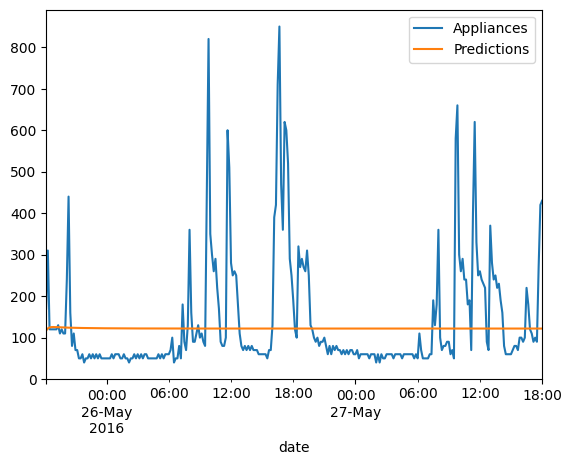

In [18]:
test_df.plot()